#  Simulation Project

In this project we studied the pressure of the hard disk system as a function of the number of particles and volume of the system. From these results we extracted the value for the volume correction parameter $b$ from the equation of Van der Waals:

$ P(\frac{V}{N}-b) = k_BT $

For this, we wrote a code that simulates the highly simplified model of “hard disks” in two dimensions. The particles were contained inside a square box where they collided with the walls and with each other.

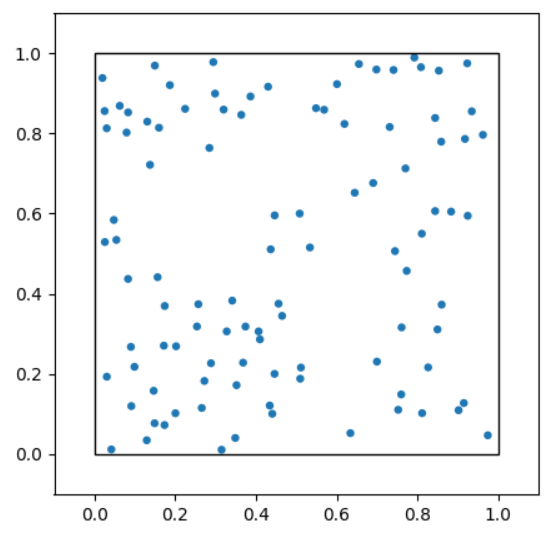


First of all, we proceed to create the properties of the class: number and radii of particles, initial random velocity and crystal distribution for the initial positions.
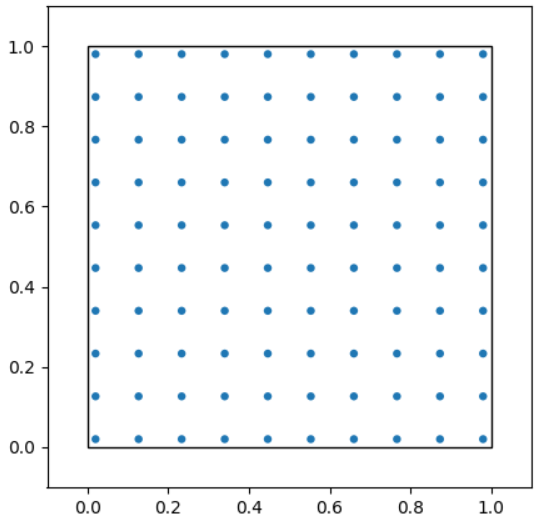

In [ ]:
def __init__(self, sample_time, sigma, L, N):
        
        self.sigma = sigma  # particle radius
        
        Nx = round(np.sqrt(N*L/L))
        Ny = round(Nx*L/L)
        self.position = np.zeros((Nx*Ny,2))
        
        posx = np.linspace(2*self.sigma, L - 2*self.sigma,Nx)
        posy = np.transpose(np.linspace(2*self.sigma, L - 2*self.sigma, Ny))
        
        #[np.newaxis]
        n = 0
        for i in range(Nx) :
            for j in range(Ny) :
                self.position[n,:] = np.array([[posx[i],posy[j]]])
                n += 1
                
        self._velocity = np.random.normal(size=self.position.shape)  # random velocities
        self._i, self._j = np.triu_indices(self.position.shape[0], k=1)  # all pairs of indices between particles
        self._sample_time=sample_time
        self.L=L
        self.boite = np.array([[L,L]])
        self.p_ =  np.array([])
        self.N = Nx*Ny

The function `_wall_time()` was used to acquire the time where the particle touched the wall ($t_c$) by knowing that the collisions could happend in any of the four walls ($x=0, y=0, x=L, y=L$) and taking the disk (particle id) and direction (component of velocity) of the particle with the smallest value for $t_{c}$

In [1]:
    def _wall_time(self):
        
        tc = np.where(self._velocity >0, ( self.L- self.sigma - self.position)/self._velocity , (0 + self.sigma - self.position)/self._velocity )
        disk, direction = np.unravel_index(tc.argmin(), tc.shape)
        
        return tc, disk, direction

On the other hand, the function `_pair_time(self)` calculates the smallest collision time between particles (tcp_p). For this, we define $\vec{r}_{ij}$ and $\vec{v}_{ij}$ as the difference of positions and velocities of the disks $i$ and $j$, respectively. These vectors were used to compute the time of collision for all combinations of the particles with the next equation: $t_{cp} = \frac{-b - \sqrt{b^2 - 4ac}}{2a}$, where $a = ||\vec{v}_{ij}||^2$, $b = 2||\vec{v}_{ij}|||\vec{r}_{ij}||$ and $c = ||\vec{r}_{ij}||^2-(\sigma_i+\sigma_j)^2$ being $\sigma$ the radius of each particle. 

The conditions considered were:

$\bullet$ The discriminant $d$ of the cuadratic equation is positive, to obtain real solutions.

$\bullet$ $b$ is negative, to cosider only the cases where the particles are aproaching each other.

$\bullet$ $c$ is positive, to consider the cases where the separation of the particles is greater than the two radii of the particles.

If this conditions are not met, a value of 1000 is assigned to the time, which is clearly greater than the smallest time of collition between particles. 

$i_c$, $j_c$, $v_i$, $v_j$ are the indices and velocitiesof the particles involved in the collision, respectively; `dif_v` is the difference between this velocities.

In [ ]:
    def _pair_time(self):
        
        i, j = np.triu_indices(self.position.shape[0], k=1)
        rij = self.position[i]-self.position[j]
        vij = self._velocity[i] - self._velocity[j]
        
        a = np.sum(vij*vij,1)
        b = 2*np.sum(rij*vij,1)
        c = np.sum(rij*rij,1) - 4*self.sigma*self.sigma
        d = b*b - 4*a*c
        
        tcp = np.where((d > 0) & (b<0) & (c>0), (-b - np.sqrt(d))/(2*a) , 1000 )
        
        tcp_p = tcp[tcp.argmin()]
        ic = i[tcp.argmin()]
        jc = j[tcp.argmin()]
        
        vi = self._velocity[ic]
        vj = self._velocity[jc]
        dif_v = vi - vj
        
        return tcp_p, ic, jc, dif_v

Once we have created these functions we go to `md_step()` where we call the returns of `pair_time()` and `wall_time()`. We compare the $t_c$ and $t_{cp}$ to select the minimum value (_tmin_) between these two. If _tmin_ is greater than _sample_time_ that means that there is no collision happening in this frame, so that the next position would be

$ r^{(t+\Delta t)} = r^{(t)} + \Delta t * v$

In the opposite case, if _tmin_ is less than _sample_time_ we have either a collision with the wall or between particles. So,the particle continues on a straight path until the time of collision and then we examine which type of impact is, to make the changes in directions (components of the velocity) for each phenomenon, taking in to account the law of conservation of energy and momentum for an elastic collision. 

This process is made inside a while loop until there are no more collisiones during the _sample_time_, and the position is recalculated with the time that is left to complete the frame. 

Besides, the pressure is calculated adding the values for each collision with the wall during the frame of the force divided by the area (as we are considering a 2D system). The kinetic energy is calculated at the end of all the collisions in the same frame, to confirm it is being conserved.

$ P = \frac{\sum_i|2*m*v_{i,c}|}{4L*\text{_sample_time_}} $

$ E_k = \frac{1}{2}\sum_i m*v_i^2 $



In [ ]:
    def md_step(self):
        
        tc,disk,direction = self._wall_time()
        tcp_p, ic, jc, dif_v = self._pair_time()        
        tmin = min(tc[disk, direction], tcp_p)
        
        pressure = 0
        
        now = 0
        while now + tmin < self._sample_time:
            now+=tmin
            
            if tc[disk, direction] < tcp_p:
                
                self.position += tc[disk, direction]*self._velocity
                self._velocity[disk, direction] = -self._velocity[disk, direction]             
                pressure += 2*1*abs(self._velocity[disk, direction])*(1/(4*self.L*self._sample_time))
            
            else:
                self.position += tcp_p* self._velocity
                u = (self.position[jc] - self.position[ic])/np.linalg.norm(self.position[jc] - self.position[ic])
                
                self._velocity[ic] -= u*np.sum(u*dif_v)
                self._velocity[jc] += u*np.sum(u*dif_v)   
                
            tc,disk,direction= self._wall_time()
            tcp_p, ic, jc, dif_v = self._pair_time()
            tmin = min(tc[disk, direction], tcp_p)   
               
        self.position = self.position + (self._sample_time-now) * self._velocity
        
        Energy = 1/2*1*np.sum(self._velocity**2)
        
        return pressure, Energy

    
    

# Project


As our project, we wrote another program called `b_VdW()`. Here, we studied the pressure of the hard disk system as a function of the density. For this, we varied the number of particles in the system $N$ and the volume $V$ of the box (area in our 2D simulation) and then used the Van der Waals equation ( $P(V/N-b) = k_B T$ ) to plot the pressure as a funtion of this variables.



In [ ]:
def b_VdW():
    
    np.random.seed(10)
    
    sample_time = 0.01
    Ni = np.linspace(10,190,10)
    Li = np.logspace(0,1,11)
    
    frames = 500
    
    t = np.zeros((frames,len(Ni),len(Li)))
    p = np.zeros((frames,len(Ni),len(Li)))
    e = np.zeros((frames,len(Ni),len(Li)))
    pi = np.zeros((len(Ni),len(Li)))
    ei = np.zeros((len(Ni),len(Li)))
    p_prom = np.array([[]])
    V_N = np.array([[]])
    e_prom = np.array([[]])
    
    for n in range(len(Ni)):
        for l in range(len(Li)):

            simulation = Simul(sample_time, sigma=0.01, L = Li[l] , N = Ni[n])  #  sigma particle radius  
        
            for i in range(frames): 
                        
                t[i,n,l] = i*sample_time
                Pressure, Energy = simulation.md_step()
                p[i,n,l] = Pressure
            
            V_N = np.append(V_N,(Li[l]**2)/Ni[n])
            pi[n,l] = np.mean(p[:,n,l])
            ei[n,l] = Energy/Ni[n]
            p_prom = np.append(p_prom,pi[n,l])
            e_prom = np.append(e_prom,ei[n,l])
            
        print(";)")
    
    sort_index = np.argsort(V_N)
    V_N = np.sort(V_N)
    e_prom = e_prom[sort_index]
    p_prom = p_prom[sort_index]
    b = V_N - e_prom/p_prom
    
    Va = Li**2
    Na = np.transpose(np.array([Ni]))
    
    Data = {'V': Va, 'N': Ni, 'V/N': V_N, 'E': e_prom, 'P': p_prom, 'bi': b, 'ei': ei, 'pi': pi, 't': t, 'p': p}
    
    with open('Data.pickle', 'wb') as file:  # this sends all the state to a file
        pickle.dump(Data,file)

# Results

Once we have saved the data, we proceed to open the documents to obtain the next graphs. Regarding the volume, we can see that we obtain results consistent with the van der Waals formula, where the pressure must be inversely proportional to the volume, and the graph must be shifted to the right by a factor of $Nb$.

Consistent results are also obtained for the $P$ vs. $N$ plot, as these quantities should be approximately proportional for a small number of particles. We obtained the graphs shown below.

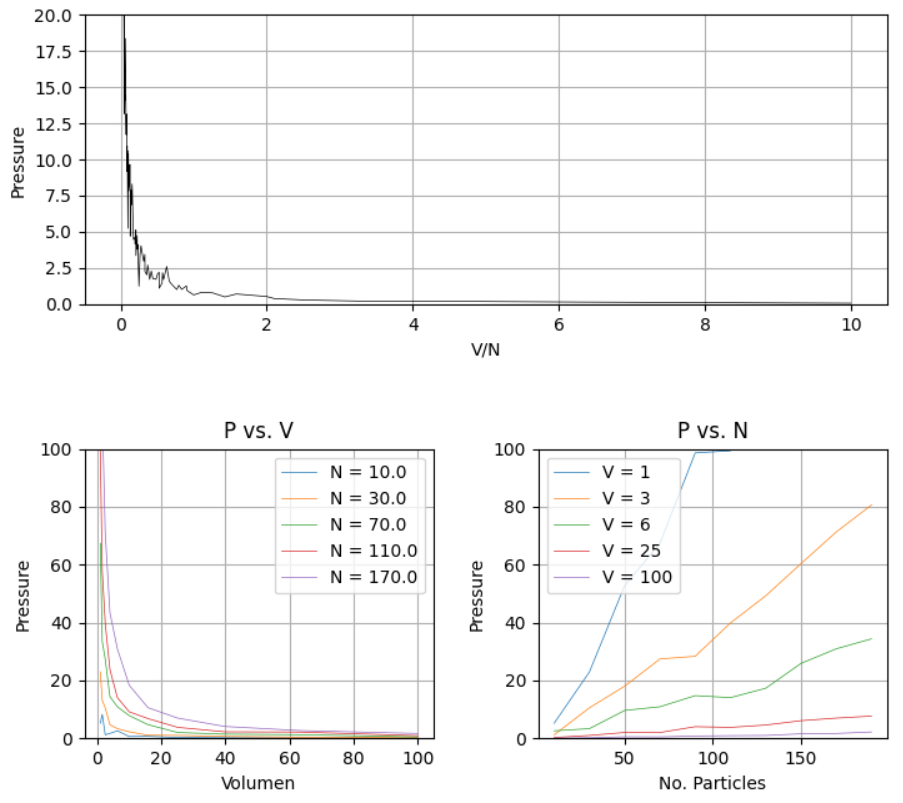

In [ ]:
with open('Data.pickle','rb') as file:
    Data = pickle.load(file)
    
V_N = Data['V/N']
P = Data['P']
pi = Data['pi']
V = Data['V']
N = Data['N']
b = Data['bi']
ei = Data['ei']
E = Data['E']
print("El valor promedio de b es:",np.mean(b))

grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.5)

plt.subplot(grid[0, :])
plt.plot(V_N,P,color='k',linewidth=0.5,label="P") 
plt.xlabel('V/N') 
plt.ylabel('Pressure')
plt.ylim(0,20)
plt.grid()

plt.subplot(grid[1, 0])
plt.plot(V,pi[0,:],linewidth=0.5,label = "N = " + str(N[0])) 
plt.plot(V,pi[1,:],linewidth=0.5,label = "N = " + str(N[1])) 
plt.plot(V,pi[3,:],linewidth=0.5,label = "N = " + str(N[3])) 
plt.plot(V,pi[5,:],linewidth=0.5,label = "N = " + str(N[5])) 
plt.plot(V,pi[8,:],linewidth=0.5,label = "N = " + str(N[8])) 
plt.ylim(0,100)
plt.xlabel('Volumen') 
plt.ylabel('Pressure') 
plt.title('P vs. V')
plt.legend()
plt.grid()

plt.subplot(grid[1,1])
plt.plot(N,pi[:,0],linewidth=0.5,label = "V = " + str(round(V[0]))) 
plt.plot(N,pi[:,2],linewidth=0.5,label = "V = " + str(round(V[2]))) 
plt.plot(N,pi[:,4],linewidth=0.5,label = "V = " + str(round(V[4]))) 
plt.plot(N,pi[:,7],linewidth=0.5,label = "V = " + str(round(V[7]))) 
plt.plot(N,pi[:,10],linewidth=0.5,label = "V = " + str(round(V[10]))) 
plt.ylim(0,100)
plt.xlabel('No. Particles') 
plt.ylabel('Pressure') 
plt.title('P vs. N') 
plt.legend()
plt.grid()

plt.show()


Considering the Van der Waals equation, we see that

$ b=\frac{V}{N}-\frac{k_BT}{P} $

Taking into account the relation between the average kinetic energy and the termic energy for a gas

$ \frac{2}{2}k_BT=\frac{1}{2}m\bar{v}^2 $

Then,

$ b =\frac{V}{N}-\frac{m*\bar{v}^2}{2P} $

According to the van der Waals equation, there must be a vertical asymptote at $N = V/b$; since this is not observed in the graph, it is intuited that $b$ must have a very small value. We compute the average value of b and we obtained:



